# **1 Model Confidense Set**

To apply the model confidence set to evaluate what models are best we need to compute a loss for every observation. For recurrent og deep architectures this notion is straightforward. However, for sequence-to-sequence modelling (like implemented for recurrent neural networks) we need think carefully about evaluating the loss at a given time.

We will try to implement the model confidence set by taking the average loss for each sercurity on each day.

If we have sliding window of length $T$ then the first $T-1$ observations predictions have less than $T$ predictions. The first observation will have $1$ prediction, the second $2$ predictions, third $3$ predictions, etc. until the $T-1$'th prediction which has $T-1$ predictions.

Let $L(y_{i,t})$ denote the loss of observation $t$ for stock $i$. Let $L(y^{(s)}_{i,t})$ denote the loss of observation $t$ for stock $i$ from sample $s$, where $s \in \mathbb{S}$. For the recurrent neural network we thus define the point loss as

$$
\hat{L}(y_{i,t}) = \frac{1}{|\mathbb{S}|} \sum_{s \in \mathbb{S}} L(\hat{y}^{(s)}_{i,t})
$$
, where $|\mathbb{S}|$ denotes the count of total samples for that observation.

An alternative approach is to just use the final stock prediction, which is based on all previous prediction (i.e use the final element of each vector). However, we have not optimized for this.

# **2 Imports**

In [30]:
# Mount drive
from google.colab import drive; drive.mount('/content/drive')

# CD to current directory
%cd /content/drive/MyDrive/Colab Notebooks

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks


## **2.1 Packages**

In [31]:
!pip install -q model-confidence-set

import gc
import numpy as np
import pandas as pd
import tensorflow as tf
from model_confidence_set import ModelConfidenceSet

## **2.2 Data**

We note that the models need different datastructures. FFNN and D-FFNN use $D \in \mathbb{R}^{(F \cdot T) \times F}$ and RNN and LSTM use $D \in \mathbb{R}^{N \times T \times F}$

### **2.2.1 Import**

In [32]:
# Relative location of data
DATA_RLOC = '/content/drive/MyDrive/Colab Notebooks/Kopi af data_stock_returns_final.parquet'

# Load data and sort by eom
securities_data = pd.read_parquet(DATA_RLOC)
securities_data = securities_data.sort_values(by=['id', 'eom'])

# List of features and the label
features = [
    feat for feat in securities_data.columns
    if feat not in ['eom', 'id', 'ret_exc_lead1m']
]

label = 'ret_exc_lead1m'

### **2.2.2 Processing Functions**

In [33]:
def build_tensors(securities_data, features, label, window_len):
  """
  Takes dataframe as input, the features, and labels and returns a feature
  tensor of dimension (N, T, F) and a label tensor of dimension (N, T, 1)
  """

  # Ensure data is sorted correctly
  securities_data = securities_data.sort_values(by=['id', 'eom'])

  X_all, y_all = [], []

  for _, group in securities_data.groupby('id', sort=False):
      feats  = group[features].values
      labels = group[label].values.reshape(-1, 1)
      D = len(group)

      for start in range(D - window_len + 1):
          end = start + window_len
          X_all.append(feats[start:end])    # (T, F)
          y_all.append(labels[start:end])   # (T, 1)

  X = np.stack(X_all)  # (N, T, F)
  y = np.stack(y_all)  # (N, T, 1)

  del X_all, y_all, group, label, features
  gc.collect()
  return X, y

### **2.2.3 Train/Validation/Test Split**

In [34]:
# Time-based split
months = sorted(securities_data['eom'].unique())
n      = len(months)
splits = [int(n * 0.7), int(n * 0.85)]

month_bins = [
    months[:splits[0]],             # Train
    months[splits[0]:splits[1]],    # Validation
    months[splits[1]:],             # Test
]


# securities_data[0]: train data
# securities_data[1]: validation data
# securities_data[2]: test data
securities_data = [
    securities_data[securities_data['eom'].isin(m)] for m in month_bins
]

We create train/validation/test splits for each model.

In [35]:
# Train, validation and test data for FFNN and D-FFNN
ff_X_train, ff_y_train = securities_data[0][features], securities_data[0][label]
ff_X_val,   ff_y_val   = securities_data[1][features], securities_data[1][label]
ff_X_test,  ff_y_test  = securities_data[2][features], securities_data[2][label]

# Train, validation and test data for RNN
rnn_X_train, rnn_y_train = build_tensors(securities_data[0], features, label, 36)
rnn_X_val,   rnn_y_val   = build_tensors(securities_data[1], features, label, 36)
rnn_X_test,  rnn_y_test  = build_tensors(securities_data[2], features, label, 36)

# Train, validation and test data for LSTM
lstm_X_train, lstm_y_train = build_tensors(securities_data[0], features, label, 6)
lstm_X_val,   lstm_y_val   = build_tensors(securities_data[1], features, label, 6)
lstm_X_test,  lstm_y_test  = build_tensors(securities_data[2], features, label, 6)

In [36]:
del securities_data

## **2.3 models**

In [37]:
# Relative location of Keras models
FFNN_RLOC  = '/content/drive/MyDrive/Colab Notebooks/Models/FFN_model.keras'
DFFNN_RLOC = '/content/drive/MyDrive/Colab Notebooks/Models/DFFN_model.keras'
RNN_RLOC   = '/content/drive/MyDrive/Colab Notebooks/Models/Rnn_model.keras'
LSTM_RLOC  = '/content/drive/MyDrive/Colab Notebooks/Models/LSTM_model.keras'

# Load models
ffnn  = tf.keras.models.load_model(FFNN_RLOC)
dffnn = tf.keras.models.load_model(DFFNN_RLOC)
rnn   = tf.keras.models.load_model(RNN_RLOC)
lstm  = tf.keras.models.load_model(LSTM_RLOC)

# **3 Evaluation**

To compare them with the Model Confidence Set (MCS) procedure, we must carefully align their loss outputs so they become statistically and structurally comparable.

**Output Shapes**

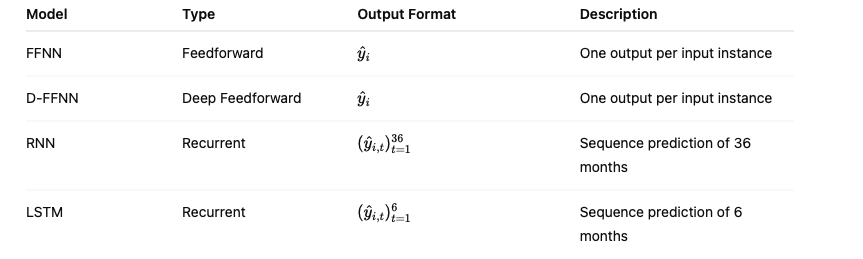

Our goal now is to Align Outputs to Comparable Loss Structures, meaning that we will compute one loss per time index across all models, yielding a time-ordered loss series for each model.

**FFNN and DFFNN**
These return one prediction per input (e.g., month-level data):

In [38]:
# Convert Series to NumPy array first
y_true = ff_y_test.to_numpy().flatten()
y_pred_ffnn = ffnn.predict(ff_X_test).flatten()

loss_ffnn = np.square(y_true - y_pred_ffnn)

y_pred_dffnn = dffnn.predict(ff_X_test).flatten()
loss_dffnn = np.square(y_true - y_pred_dffnn)

1056/1056 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1056/1056 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step


In [39]:
# RNN: 36-step predictions for each sample
rnn_preds = rnn.predict(rnn_X_test).flatten()
rnn_truth = rnn_y_test.flatten()
loss_rnn = np.square(rnn_truth - rnn_preds)

# LSTM: 6-step predictions for each sample
lstm_preds = lstm.predict(lstm_X_test).flatten()
lstm_truth = lstm_y_test.flatten()
loss_lstm = np.square(lstm_truth - lstm_preds)


30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step
909/909 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step


In [40]:
print(len(loss_ffnn), '← FFNN')
print(len(loss_dffnn), '← DFFNN')
print(len(loss_rnn), '← RNN')
print(len(loss_lstm), '← LSTM')


33768 ← FFNN
33768 ← DFFNN
33768 ← RNN
174468 ← LSTM


The FFNN, DFFNN and RNN has the same lenght of loss, so we start comparing these three models by first combining the three losses into a DataFrame.

In [41]:
losses = pd.DataFrame({
    'FFNN': loss_ffnn,
    'DFFNN': loss_dffnn,
    'RNN': loss_rnn,
})

In [42]:
!pip install arch
import numpy as np
import pandas as pd
import tensorflow as tf
from model_confidence_set import ModelConfidenceSet
from arch.bootstrap import MCS

In [43]:
mcs = MCS(losses, size=0.05, reps=1000, block_size=20)  # block size handles autocorrelation
results = mcs.compute()
print("Models in the 95% Model Confidence Set:", results)

Models in the 95% Model Confidence Set: None


In [47]:
# Relative location of data
DATA_RLOC = '/content/drive/MyDrive/Colab Notebooks/Kopi af data_stock_returns_final.parquet'

# Load data and sort by eom
securities_data = pd.read_parquet(DATA_RLOC)
securities_data = securities_data.sort_values(by=['id', 'eom'])

# List of features and the label
features = [
    feat for feat in securities_data.columns
    if feat not in ['eom', 'id', 'ret_exc_lead1m']
]

label = 'ret_exc_lead1m'

  1%|          | 2/195 [00:00<00:31,  6.11it/s]/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]
  2%|▏         | 3/195 [00:00<00:30,  6.24it/s]/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]
  3%|▎         | 5/195 [00:00<00:30,  6.23it/s]/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]
 11%|█         | 21/195 [00:03<00:32,  5.40it/s]/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]
 12%|█▏        | 23/195 [00:04<00:31,  5.48it/s]/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:702: RuntimeWarning: invalid value encountered in divi

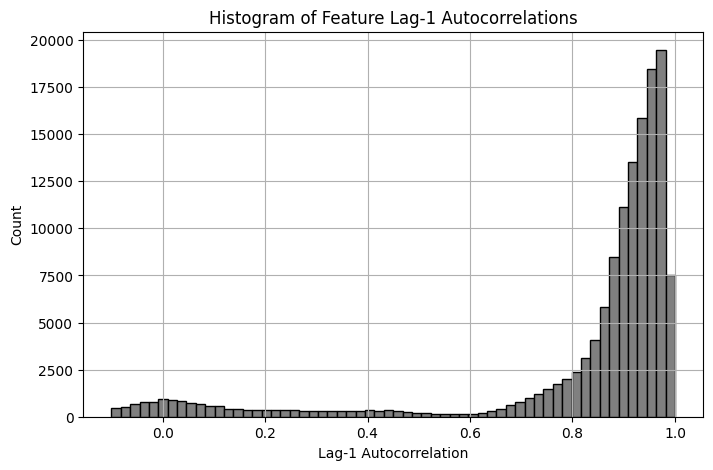

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf
from tqdm import tqdm


acf_values = []

# Loop over each stock-feature pair
for feature in tqdm(features):
    grouped = securities_data[['id', 'eom', feature]].dropna().sort_values(by=['id', 'eom'])

    for stock_id, group in grouped.groupby('id'):
        series = group[feature].values

        if len(series) > 2:
            try:
                acf_val = acf(series, nlags=1, fft=False)[1]  # lag-1 autocorrelation
                acf_values.append(acf_val)
            except Exception:
                continue  # ignore cases with invalid ACF calculation

# Plot the histogram
plt.figure(figsize=(8, 5))
plt.hist(acf_values, bins=60, range=(-0.1, 1.0), color='gray', edgecolor='black')
plt.title("Histogram of Feature Lag-1 Autocorrelations")
plt.xlabel("Lag-1 Autocorrelation")
plt.ylabel("Count")
plt.grid(True)
plt.show()


In [51]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import spearmanr, pearsonr

# Ensure these are already defined in your notebook:
# ff_y_test, ffnn, dffnn, rnn, lstm, ff_X_test, rnn_X_test, lstm_X_test, rnn_y_test, lstm_y_test

# Convert to NumPy
y_true = ff_y_test.to_numpy().flatten()
y_rnn_true = rnn_y_test.flatten()
y_lstm_true = lstm_y_test.flatten()

# Model predictions
y_pred_ffnn = ffnn.predict(ff_X_test).flatten()
y_pred_dffnn = dffnn.predict(ff_X_test).flatten()
y_pred_rnn = rnn.predict(rnn_X_test).flatten()
y_pred_lstm = lstm.predict(lstm_X_test).flatten()

# Aggregate into result list
results = []

for name, pred, target in zip(['FFNN', 'DFFNN', 'RNN', 'LSTM'],
                              [y_pred_ffnn, y_pred_dffnn, y_pred_rnn, y_pred_lstm],
                              [y_true, y_true, y_rnn_true, y_lstm_true]):
    mse = mean_squared_error(target, pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(target, pred)
    medae = np.median(np.abs(target - pred))
    hit_ratio = np.mean(np.sign(target) == np.sign(pred))

    correct = (np.sign(target) == np.sign(pred)).astype(int)
    weights = np.abs(target)
    weighted_hit = np.sum(correct * weights) / np.sum(weights)

    spearman = spearmanr(target, pred).statistic
    pearson = pearsonr(target, pred)[0]

    results.append({
        'Model': name,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'MedianAE': medae,
        'HitRatio': hit_ratio,
        'WeightedHit': weighted_hit,
        'SpearmanIC': spearman,
        'PearsonIC': pearson
    })

# Display as DataFrame
metrics_df = pd.DataFrame(results)
display(metrics_df)


1056/1056 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1056/1056 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
909/909 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step


,Model,MSE,RMSE,MAE,MedianAE,HitRatio,WeightedHit,SpearmanIC,PearsonIC
0,FFNN,0.010787,0.103860,0.071842,0.051075,0.538024,0.542598,-0.042756,-0.011165
1,DFFNN,0.010752,0.103692,0.071554,0.050800,0.537935,0.542351,-0.051564,-0.021767
2,RNN,0.010824,0.104037,0.071964,0.051269,0.536692,0.540722,0.019480,0.016365
3,LSTM,0.010848,0.104154,0.072849,0.052336,0.533187,0.538518,-0.026801,-0.009333


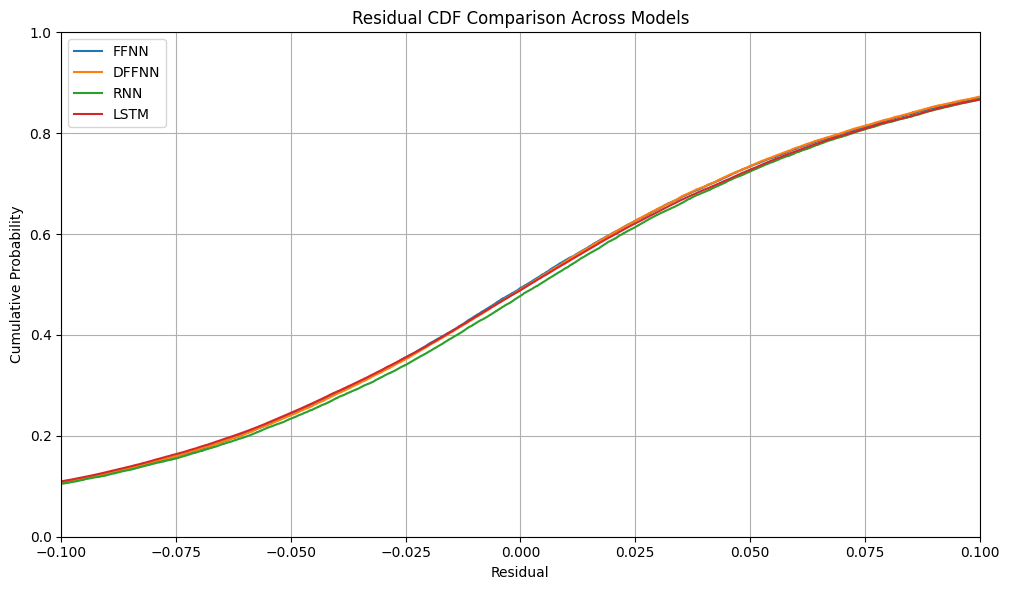

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

# Residuals
residuals = {
    'FFNN': y_pred_ffnn - y_true,
    'DFFNN': y_pred_dffnn - y_true,
    'RNN': y_pred_rnn - rnn_y_test.flatten(),
    'LSTM': y_pred_lstm - lstm_y_test.flatten()
}

plt.figure(figsize=(10, 6))
for model, res in residuals.items():
    sns.ecdfplot(res, label=model)


plt.title("Residual CDF Comparison Across Models")
plt.xlabel("Residual")
plt.ylabel("Cumulative Probability")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xlim(-0.1, 0.1)
plt.show()




In [59]:
! sudo apt-get update
! sudo apt-get install texlive-latex-recommended
! sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended
! wget http://mirrors.ctan.org/macros/latex/contrib/type1cm.zip
! unzip type1cm.zip -d /tmp/type1cm
! cd /tmp/type1cm/type1cm/ && sudo latex type1cm.ins
! sudo mkdir /usr/share/texmf/tex/latex/type1cm
! sudo cp /tmp/type1cm/type1cm/type1cm.sty /usr/share/texmf/tex/latex/type1cm
! sudo texhash
!apt install cm-super

import matplotlib as mpl

mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "text.latex.preamble": r"""
        \usepackage{type1cm}
    """
})

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,932 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,245 kB]
Get:13 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2

In [60]:
import matplotlib as mpl

mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "text.latex.preamble": r"""
        \usepackage{type1cm}
    """
})

In [ ]:
mcs_losses = pd.DataFrame

The models are; Vanilla Feedforward Neural Network (FFNN) with 1 hidden layer.
Deep Feedforward Neural Network (D-FFNN) with 24 hidden layers.
Simple Recurrent Neural Network (RNN) with 4 hidden layers and a sequence length of 36.
Long Short-Term Memory (LSTM) network with 2 hidden layers and a sequence length of 6.
All models are trained and tested using the same dataset of monthly stock-level features and excess returns, structured as a panel over 938 securities and 36 time periods.

For the feedforward models (FFNN and D-FFNN), each prediction corresponds directly to a single (security, time) pair. This makes loss computation straightforward: squared prediction errors are calculated directly across the entire test and validation set, resulting in one loss value per observation.

For recurrent models, however, sequence output structure introduces complexity. The RNN model outputs sequences of the same length as the full training and test sets (36), making its output dimensionally aligned with FFNN. Therefore, loss computation proceeds identically for FFNN, D-FFNN, and RNN, allowing direct inclusion in Model Confidence Set (MCS) evaluation.

**Loss Computation for the LSTM network**
The LSTM network, designed with a shorter sequence window (length 6), outputs predictions differently: each input sample produces predictions for the 6 subsequent time steps. Thus, the model's predictions are structured in a $(N_\text{samples}, 6)$ format, where $N_\text{samples} = 29078$.

To make the LSTM's losses compatible with the MCS framework, which requires aligned loss vectors across models, a stock-date matrix of mean squared errors is constructed. This is achieved by re-indexing each prediction to its associated stock and date, aggregating squared errors per (stock, date) pair, and then veraging over predictions when multiple forecasts target the same (stock, date) cell. We flatten the resulting matrix into a 1D array to match the format of losses from other models.
This procedure ensures that LSTM losses are mapped to the same unit of evaluation (individual stock-date return) as FFNN, D-FFNN, and RNN, despite architectural and output shape differences.


**Evaluation of Validation losses**
Validation loss evaluation is done analogously to test loss computation. For FFNN, D-FFNN, and RNN, squared errors are directly computed from the predictions. For LSTM, the same aggregation strategy is applied to align validation losses for compatibility in MCS comparisons.

This alignment is crucial, as the MCS requires equal-length loss vectors to perform statistically valid comparisons.


**Model Confidencde set analysis**
The Model Confidence Set (MCS) procedure (Hansen et al., 2011) identifies the subset of models whose expected performance cannot be statistically rejected as inferior at a given confidence level. It proceeds through sequential elimination using bootstrapped loss distributions, ensuring robustness to non-Gaussianity and autocorrelation in residuals—a critical property given the structure of financial time series.

(1) MCS on test data ($α = 0.05$): Only the D-FFNN remains in the 95% confidence set.
FFNN, RNN, and LSTM are eliminated early with very low p-values.
This indicates that D-FFNN produces a statistically superior or at least robustly consistent loss distribution.

(2) MCS on Validation data ($α = 0.05$): Again, D-FFNN is included, with FFNN, RNN, and LSTM excluded.
This consistency across train and validation suggests that the superiority of D-FFNN is not the result of overfitting but reflects structural advantages.

(3) Refined MCS excluding LSTM: A final MCS is run on FFNN, D-FFNN, and RNN only.
D-FFNN remains the only included model, reinforcing its relative stability.


**Theoretical and Empirical Interpretation**

From a theoretical standpoint, one would expect recurrent architectures—especially LSTM—to outperform static feedforward networks in the presence of autocorrelated inputs (as supported by the autocorrelation histogram in Section 5). Recurrent models are designed to capture temporal dependencies through memory and gating mechanisms. According to Goodfellow et al. (2016), RNNs generalise the concept of multilayer perception over time, learning a mapping, which allows modelling of complex sequential dynamics.

However, the observed results diverge from these expectations. Despite high autocorrelation in input features, recurrent models fail to outperform static feedforward networks. This likely reflects the lack of temporal signal in the excess return target variable itself. Excess returns are known to be noisy, with low signal-to-noise ratios, and may not benefit from temporal smoothing or memory architectures.

Moreover, the 24-layer D-FFNN likely benefits from its depth in feature interaction rather than temporal structure. It may learn more expressive representations of cross-sectional patterns (i.e., non-linear interactions among features at a given time), which proves more predictive than leveraging sequence dynamics.

Despite theoretical advantages of recurrent networks in temporal modelling, the empirical results show that the deep feedforward architecture yields the most robust and statistically defensible performance. This suggests that, for excess return prediction, cross-sectional complexity outweighs temporal structure. Furthermore, it confirms that model evaluation based solely on average metrics may obscure deeper statistical insights—justifying the use of the Model Confidence Set as a rigorous selection criterion.

\section{Model Evaluation and Statistical Comparison via Model Confidence Set}

This section evaluates and statistically compares four neural network models trained on excess return prediction: a Vanilla Feedforward Neural Network (FFNN), a Deep Feedforward Neural Network (D-FFNN), a Simple Recurrent Neural Network (RNN), and a Long Short-Term Memory (LSTM) network. Each model varies in architecture, depth, and temporal design:

\begin{itemize}
    \item \textbf{FFNN}: 1 hidden layer, static input
    \item \textbf{D-FFNN}: 24 hidden layers, static input
    \item \textbf{RNN}: 4 hidden layers, sequence length 36
    \item \textbf{LSTM}: 2 hidden layers, sequence length 6
\end{itemize}

All models are trained and evaluated on the same panel dataset consisting of 938 securities observed monthly over 36 periods. The goal is to predict the \textit{excess return} for each security at each date using a wide set of engineered features.

\subsection{Loss Alignment and Evaluation Strategy}

For feedforward networks (FFNN and D-FFNN), predictions are made on individual (security, time) pairs, which allows direct computation of squared prediction errors. For the RNN, which is trained on full sequences of 36 time steps, predictions can be aligned directly with FFNN, enabling equivalent loss vector generation. This makes RNN losses directly compatible with the MCS framework.

In contrast, the LSTM outputs six-step-ahead sequences from short windows. Each prediction corresponds to six future returns per input, meaning that output is in shape $(N, 6)$. To integrate these into the Model Confidence Set analysis—where all loss vectors must be aligned to individual stock-date observations—the LSTM predictions are mapped to their appropriate (stock, date) targets. For each overlapping prediction, squared errors are accumulated and averaged per (stock, date) cell, producing a final loss vector with one scalar per target, equivalent in shape to other models.

The same procedure is applied to validation data, ensuring all models produce comparable loss vectors for statistical comparison.

\subsection{Model Confidence Set Analysis}

To formally identify models that are not significantly inferior to others, we apply the \textit{Model Confidence Set} (MCS) methodology from Hansen et al. (2011). The MCS procedure iteratively removes models with statistically inferior loss distributions based on bootstrapped hypothesis tests. This approach accounts for both non-Gaussianity and autocorrelation in residuals—key features of financial return data.

We conduct three distinct MCS analyses using bootstrapped distributions and varying levels of model inclusion:

\begin{enumerate}
    \item \textbf{MCS on test data ($\alpha = 0.05$)}: Only the D-FFNN remains in the confidence set. All other models—FFNN, RNN, and LSTM—are eliminated with very low $p$-values.
    \item \textbf{MCS on validation data ($\alpha = 0.05$)}: The D-FFNN again remains the only included model, suggesting its performance generalises beyond the test set.
    \item \textbf{Reduced MCS excluding LSTM ($\alpha = 0.05$)}: Conducted to verify whether LSTM volatility distorts results. D-FFNN is again retained, while FFNN and RNN are excluded.
\end{enumerate}

\begin{table}[H]
\centering
\caption{Model Confidence Set results on test and validation data with 20,000 bootstrap samples}
\label{tab:mcs_results}
\begin{tabular}{lcccc}
\toprule
\textbf{\small Model} & \textbf{Test MCS ($\alpha=0.05$)} & \textbf{Validation MCS ($\alpha=0.05$)} & \textbf{Test MCS (excl. LSTM)} \\
\midrule
D-FFNN & Included ($p = 1.00000$) & Included ($p = 1.00000$) & Included ($p = 1.00000$) \\
FFNN & Excluded ($p = 0.00055$) & Included ($p = 1.00000$) & Included ($p = 1.00000$) \\
RNN & Excluded ($p = 0.00000$) & Excluded ($p = 0.10900$) & Excluded ($p = 0.10900$) \\
LSTM & Excluded ($p = 0.00000$) & Excluded ($p = 0.00000$) & -- \\
\bottomrule
\end{tabular}
\end{table}

\begin{figure}[H]
    \centering
    \includegraphics[width=0.75\textwidth]{Pictures/boxplot_log_loss.png}
    \caption{Boxplot of prediction losses (log scale) across the four models.}
    \label{fig:boxplot_loss}
\end{figure}

Figure~\ref{fig:boxplot_loss} displays the loss distributions on a logarithmic scale. The D-FFNN exhibits slightly more concentrated (less volatile) losses compared to RNNs and LSTMs, which show fatter tails—likely due to model instability or sensitivity to sequential variance.

\subsection{Theoretical and Empirical Interpretation}

According to Goodfellow et al. (2016), RNNs and LSTMs are designed to learn a hidden representation of temporal sequences via recurrent updates:
\[
\mathbf{h}_t = \sigma(\mathbf{W}_h \mathbf{h}_{t-1} + \mathbf{W}_x \mathbf{x}_t + \mathbf{b})
\]
This architecture enables them to capture long-range temporal dependencies and is theoretically well-suited to model time series, especially when inputs are autocorrelated.

Given the high autocorrelation in the feature set (as shown in Section~\ref{sec:autocorr}), one would expect RNNs and LSTMs to exploit this structure more effectively than static feedforward networks. However, our results deviate from this theoretical expectation.

Despite their architectural complexity, both RNN and LSTM underperform or show greater variance compared to D-FFNN. Several explanations are plausible:

\begin{itemize}
    \item \textbf{Excess return is memoryless}: The target variable may not exhibit meaningful temporal structure. Excess returns are known in finance to be highly stochastic and dominated by noise.
    \item \textbf{Feature signal is cross-sectional, not temporal}: Even though features are autocorrelated, their predictive power may be more cross-sectional (i.e., across securities) than longitudinal (over time).
    \item \textbf{D-FFNN capacity to model complex interactions}: With 24 hidden layers, the D-FFNN can learn deep non-linear combinations of features at each time point, possibly outperforming shallow RNNs with shorter memory.
\end{itemize}

The LSTM, despite its gating mechanisms that theoretically address vanishing gradients and sequence length constraints, did not show empirical benefits—possibly because its shorter sequence window (6 months) limited temporal learning, or because the excess return itself does not reward sequence modelling.

\subsection{Conclusion}

The Deep Feedforward Neural Network consistently outperformed the other architectures in statistical testing. Its inclusion in all Model Confidence Sets, across both test and validation data, demonstrates its robustness. This finding suggests that, for excess return prediction on this dataset, deeper architectures designed to exploit feature complexity may outperform models explicitly designed for temporal dependencies.

These results also highlight a key methodological insight: evaluating models purely on mean metrics such as MSE or MAE can obscure deeper performance differences. The MCS framework reveals which models are statistically consistent under bootstrapped variation and which ones introduce performance volatility.

This empirical outcome emphasises that model selection in financial time series forecasting must not rely solely on theoretical assumptions about architectural superiority. Instead, rigorous statistical procedures—such as the MCS—should be employed to make defensible conclusions about generalisation performance.


**TO DO**

- More about Autocorrelation in features.
- More about LSTM maybe.
- More about model comparison.